<div style = "background-color : #ff3300; text-align : center; box-shadow : rgba(0, 0, 0, 0.24), 0px 3px 8px; color : white; font-family : Lucida Console">
    <h2 style = "padding-top : 10px; padding-bottom : 10px;">
        PREDICTING FLIGHT TICKET PRICES
    </h2>
</div>

<center> <img src="https://img.freepik.com/free-photo/airplane-red-white-background-flat-lay-travel-concept_169016-28747.jpg"/> </center>

# Table of Contents:
* ## [Introduction](#introduction)

* ## [Scraped Data EDA](#eda)

* ## [Handling Categorical Data](#cat_data)

* ## [Features](#feature)

* ## [Modeling](#modeling)

* ## [Saving The Final Model](#model)

## Introduction: <a class="anchor" id="introduction"></a>

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt

sns.set()

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Scraped Data EDA: <a class="anchor" id="eda"></a>
### Loading the scraped data

In [20]:
df1 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/NYC_PAR.csv")
df2 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/NYC_RUH.csv")
df3 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/NYC_SVO.csv")
df4 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/PAR_NYC.csv")
df5 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/PAR_RUH.csv")
df6 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/PAR_SVO.csv")
df7 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/RUH_NYC.csv")
df8 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/RUH_PAR.csv")
df9 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/RUH_SVO.csv")
df10 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/SVO_NYC.csv")
df11 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/SVO_PAR.csv")
df12 = pd.read_csv("C:/Users/Lenovo/Desktop/flight-price-prediction-main/data/SVO_RUH.csv")

In [21]:
df1.head()

,Airline,Source,Destination,Duration,Total stops,Price,Date
0,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
1,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
2,Air France,NYC,PAR,7h 20m,nonstop,"1,031 SAR",2022-02-01
3,Air France,NYC,PAR,7h 10m,nonstop,"1,238 SAR",2022-02-01
4,Air France,NYC,PAR,7h 20m,nonstop,"1,238 SAR",2022-02-01


In [22]:
df1.dtypes

Airline        object
Source         object
Destination    object
Duration       object
Total stops    object
Price          object
Date           object
dtype: object

In [23]:
# convert duration to numerical format in minutes

def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) # Extract minutes from duration

    dur = []
    for i in range(len(duration)):
        dur.append(duration_hours[i] * 60 + duration_mins[i])
    return dur

# convert price to numerical format in usd

def clean_price(price):
    price = price.str.replace(",", "", regex = True)
    price = price.str.replace("SAR", "", regex = True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)/3.75, 2)
    return price

# convert date to datetime format

def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers

def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return(lower_lim, upper_lim)

# get average of each airline

def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")

    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y
                                    

In [24]:
dfs_raw = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12]

In [25]:
# cleaning the data

dfs = []
for df in dfs_raw:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16560\169559342.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16560\169559342.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16560\169559342.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16560\169559342.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t_ = t_.append(t)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16560\169559342.py:60: FutureWarning: The frame.append method is deprec

### Studying Outliers

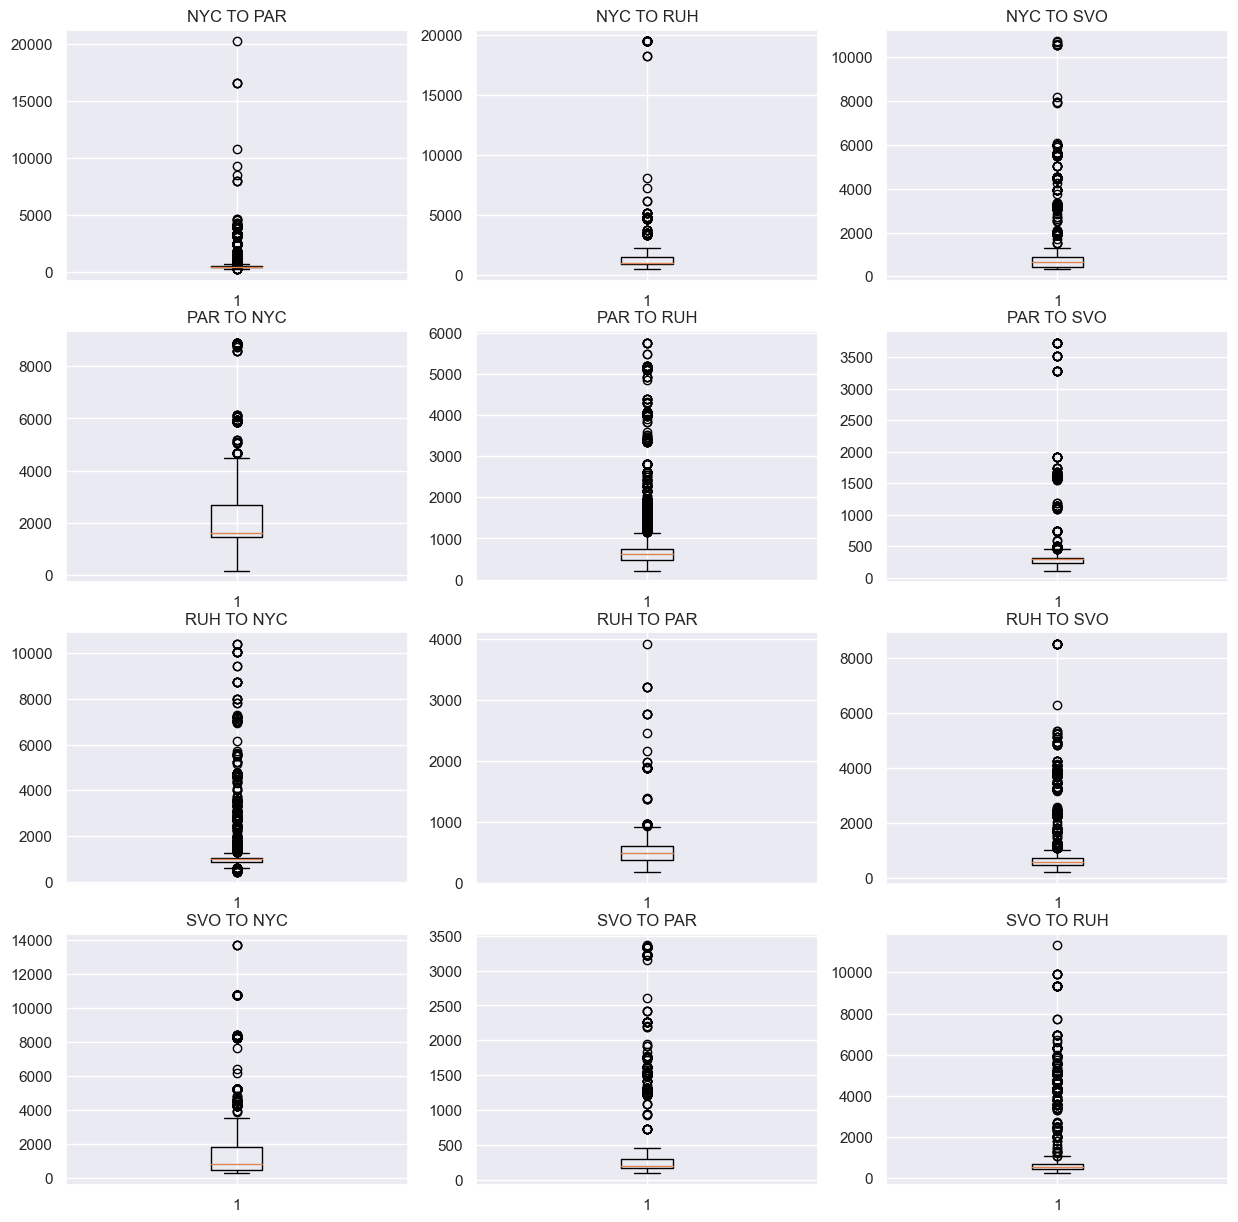

In [26]:
# boxplots for each route

k =0
figure, axis = plt.subplots(4, 3, figsize = (15, 15))
for i in range(4):
    for j in range(3):
        axis[i, j].boxplot(dfs[k]["Price"])
        axis[i, j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### It is apparent that all routes have outliers, so we'll deal with them by IQR

In [27]:
# get quantile to deal with outliers

lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df["Price"])
    lower.append(x[0])
    upper.append(x[1])

In [28]:
# drop outliers

k = 0
for df in dfs:
    low = df["Price"] < lower[k]
    up = df["Price"] > upper[k]
    df["Price"] = df["Price"][~(low|up)]
    df.dropna(inplace = True)
    df.reset_index(drop = True, inplace = True)
    k += 1

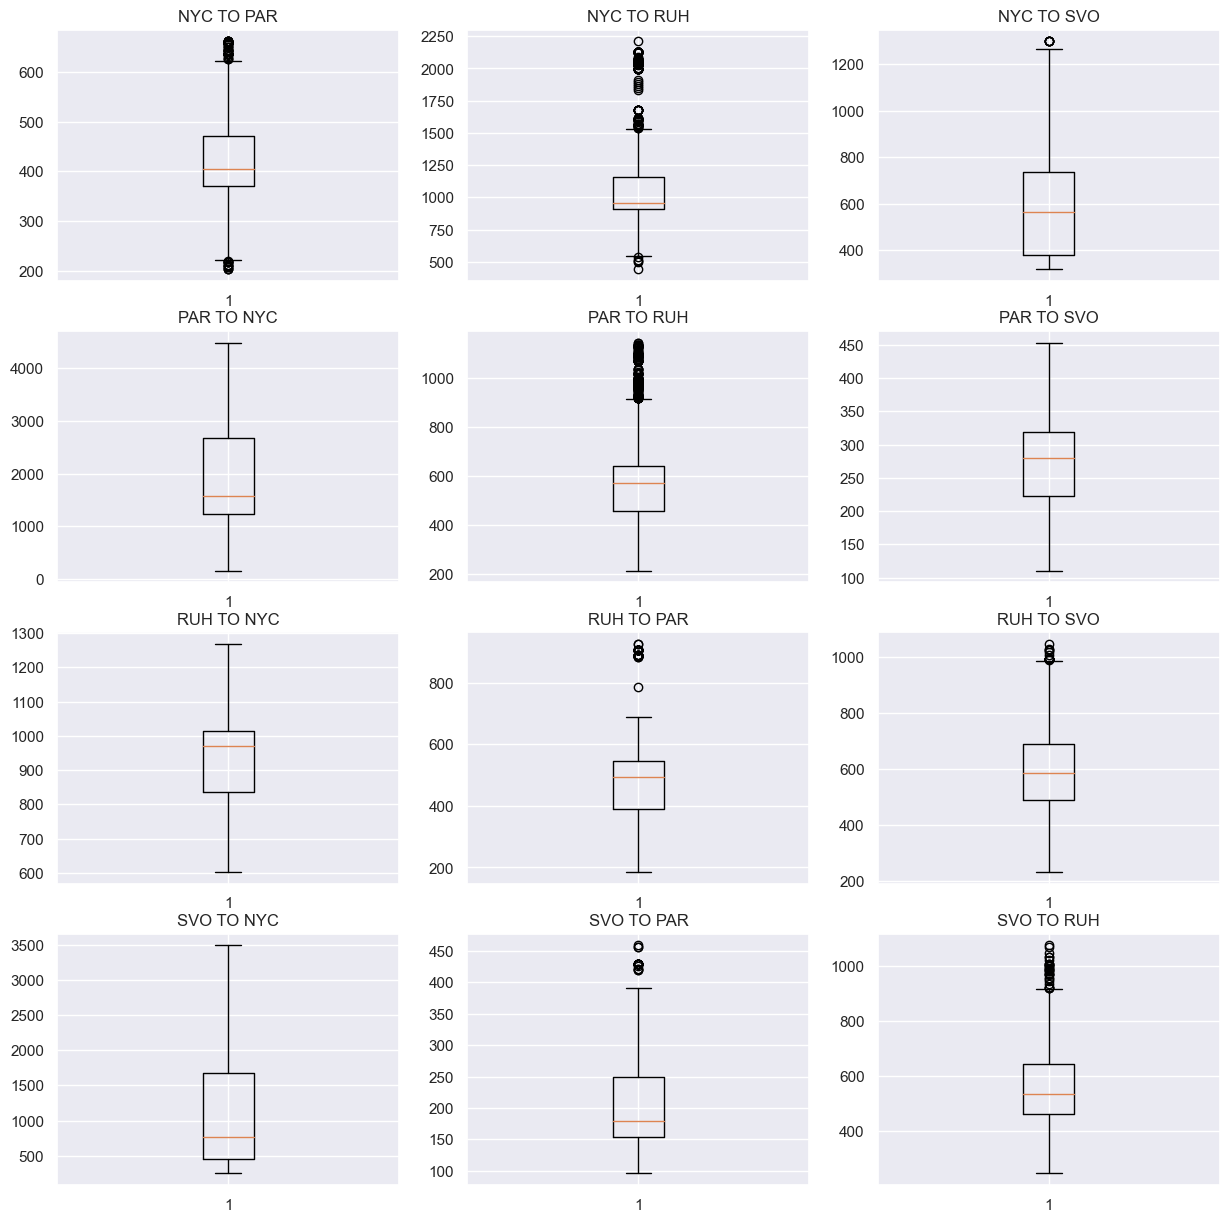

In [29]:
# boxplot for each route after dealing with outliers

k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [30]:
# concat all routes into one dataframe

df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,Air France,NYC,PAR,440,nonstop,274.93,2022-02-01,422.364573
1,Air France,NYC,PAR,440,nonstop,274.93,2022-02-01,422.364573
2,Air France,NYC,PAR,440,nonstop,274.93,2022-02-01,422.364573
3,Air France,NYC,PAR,430,nonstop,330.13,2022-02-01,422.364573
4,Air France,NYC,PAR,440,nonstop,330.13,2022-02-01,422.364573
...,...,...,...,...,...,...,...,...
1869,"Finnair, Aegean Airlines",SVO,RUH,1255,3 stops,493.33,2022-04-28,572.028760
1870,"KLM, Turkish Airlines",SVO,RUH,1120,2 stops,778.67,2022-04-21,1058.422054
1871,"KLM, Turkish Airlines",SVO,RUH,1120,2 stops,789.87,2022-04-29,1058.422054
1872,"KLM, Turkish Airlines",SVO,RUH,1120,2 stops,687.20,2022-04-30,1058.422054


In [31]:
# check for null values

df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

## Handling Categorical Data: <a class="anchor" id="cat_data"></a>

In [32]:
# the Airline column will be replaced by the average price per airline

df.drop("Airline", axis = 1, inplace = True)

In [33]:
# source

df["Source"].value_counts()

PAR    23054
NYC     9411
RUH     9140
SVO     8492
Name: Source, dtype: int64

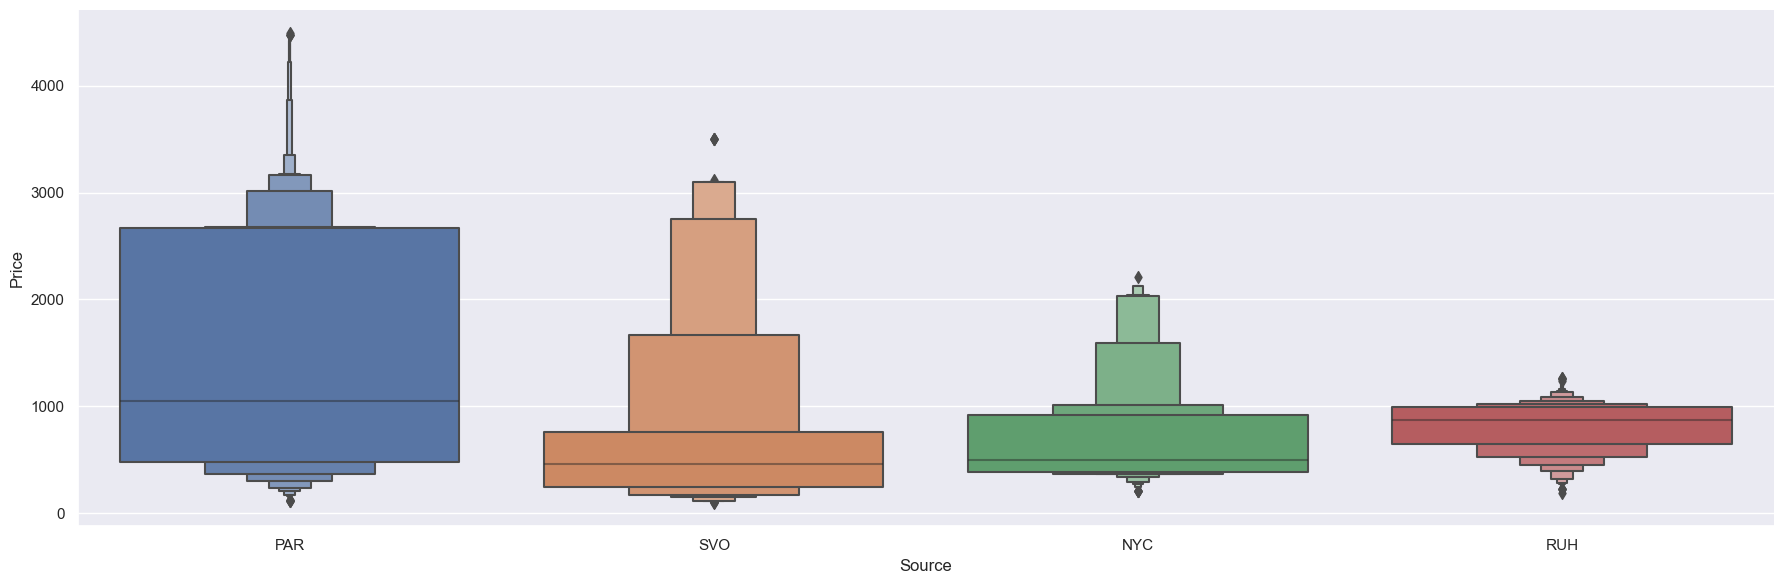

In [34]:
# source vs price

sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [35]:
# performing OneHotEncoding on Source since it's nominal categorical data

source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_PAR,Source_RUH,Source_SVO
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [36]:
# destination

df["Destination"].value_counts()

NYC    24926
RUH    11046
PAR     8042
SVO     6083
Name: Destination, dtype: int64

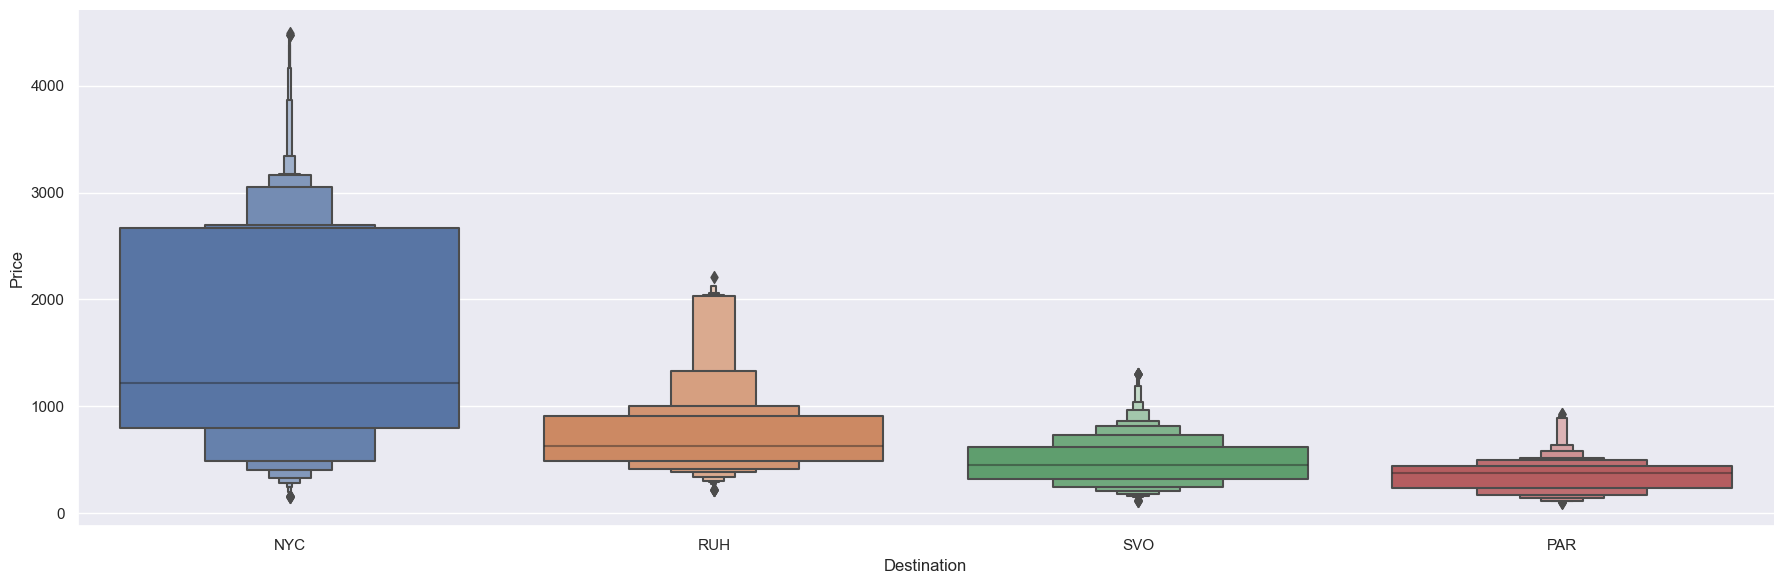

In [37]:
# destination vs price

sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [38]:
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_PAR,Destination_RUH,Destination_SVO
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [39]:
# total stops

print(df["Total stops"].value_counts())
df["Total stops"].unique()

1 stop      27466
2 stops     18665
3 stops      1988
nonstop      1978
Name: Total stops, dtype: int64


array(['nonstop ', '1 stop ', '2 stops ', '3 stops '], dtype=object)

In [40]:
# performing LabelEncoder on Total stops since it's ordinal categorical data

df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [41]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [42]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,NYC,PAR,440,0,274.93,2022-02-01,422.364573,0,0,0,1,0,0
1,NYC,PAR,440,0,274.93,2022-02-01,422.364573,0,0,0,1,0,0
2,NYC,PAR,440,0,274.93,2022-02-01,422.364573,0,0,0,1,0,0
3,NYC,PAR,430,0,330.13,2022-02-01,422.364573,0,0,0,1,0,0
4,NYC,PAR,440,0,330.13,2022-02-01,422.364573,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50092,SVO,RUH,1255,3,493.33,2022-04-28,572.028760,0,0,1,0,1,0
50093,SVO,RUH,1120,2,778.67,2022-04-21,1058.422054,0,0,1,0,1,0
50094,SVO,RUH,1120,2,789.87,2022-04-29,1058.422054,0,0,1,0,1,0
50095,SVO,RUH,1120,2,687.20,2022-04-30,1058.422054,0,0,1,0,1,0


In [43]:
# drop date since it'll not be used as a feature

final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [44]:
final_df

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,440,0,274.93,422.364573,0,0,0,1,0,0
1,440,0,274.93,422.364573,0,0,0,1,0,0
2,440,0,274.93,422.364573,0,0,0,1,0,0
3,430,0,330.13,422.364573,0,0,0,1,0,0
4,440,0,330.13,422.364573,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
50092,1255,3,493.33,572.028760,0,0,1,0,1,0
50093,1120,2,778.67,1058.422054,0,0,1,0,1,0
50094,1120,2,789.87,1058.422054,0,0,1,0,1,0
50095,1120,2,687.20,1058.422054,0,0,1,0,1,0


In [45]:
final_df.shape

(50097, 10)

In [46]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_PAR         0
Source_RUH         0
Source_SVO         0
Destination_PAR    0
Destination_RUH    0
Destination_SVO    0
dtype: int64

## Features: <a class="anchor" id="feature"></a>

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [47]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [48]:
x = final_df[['Duration', 'Total stops', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO']]

y = final_df["Price"]

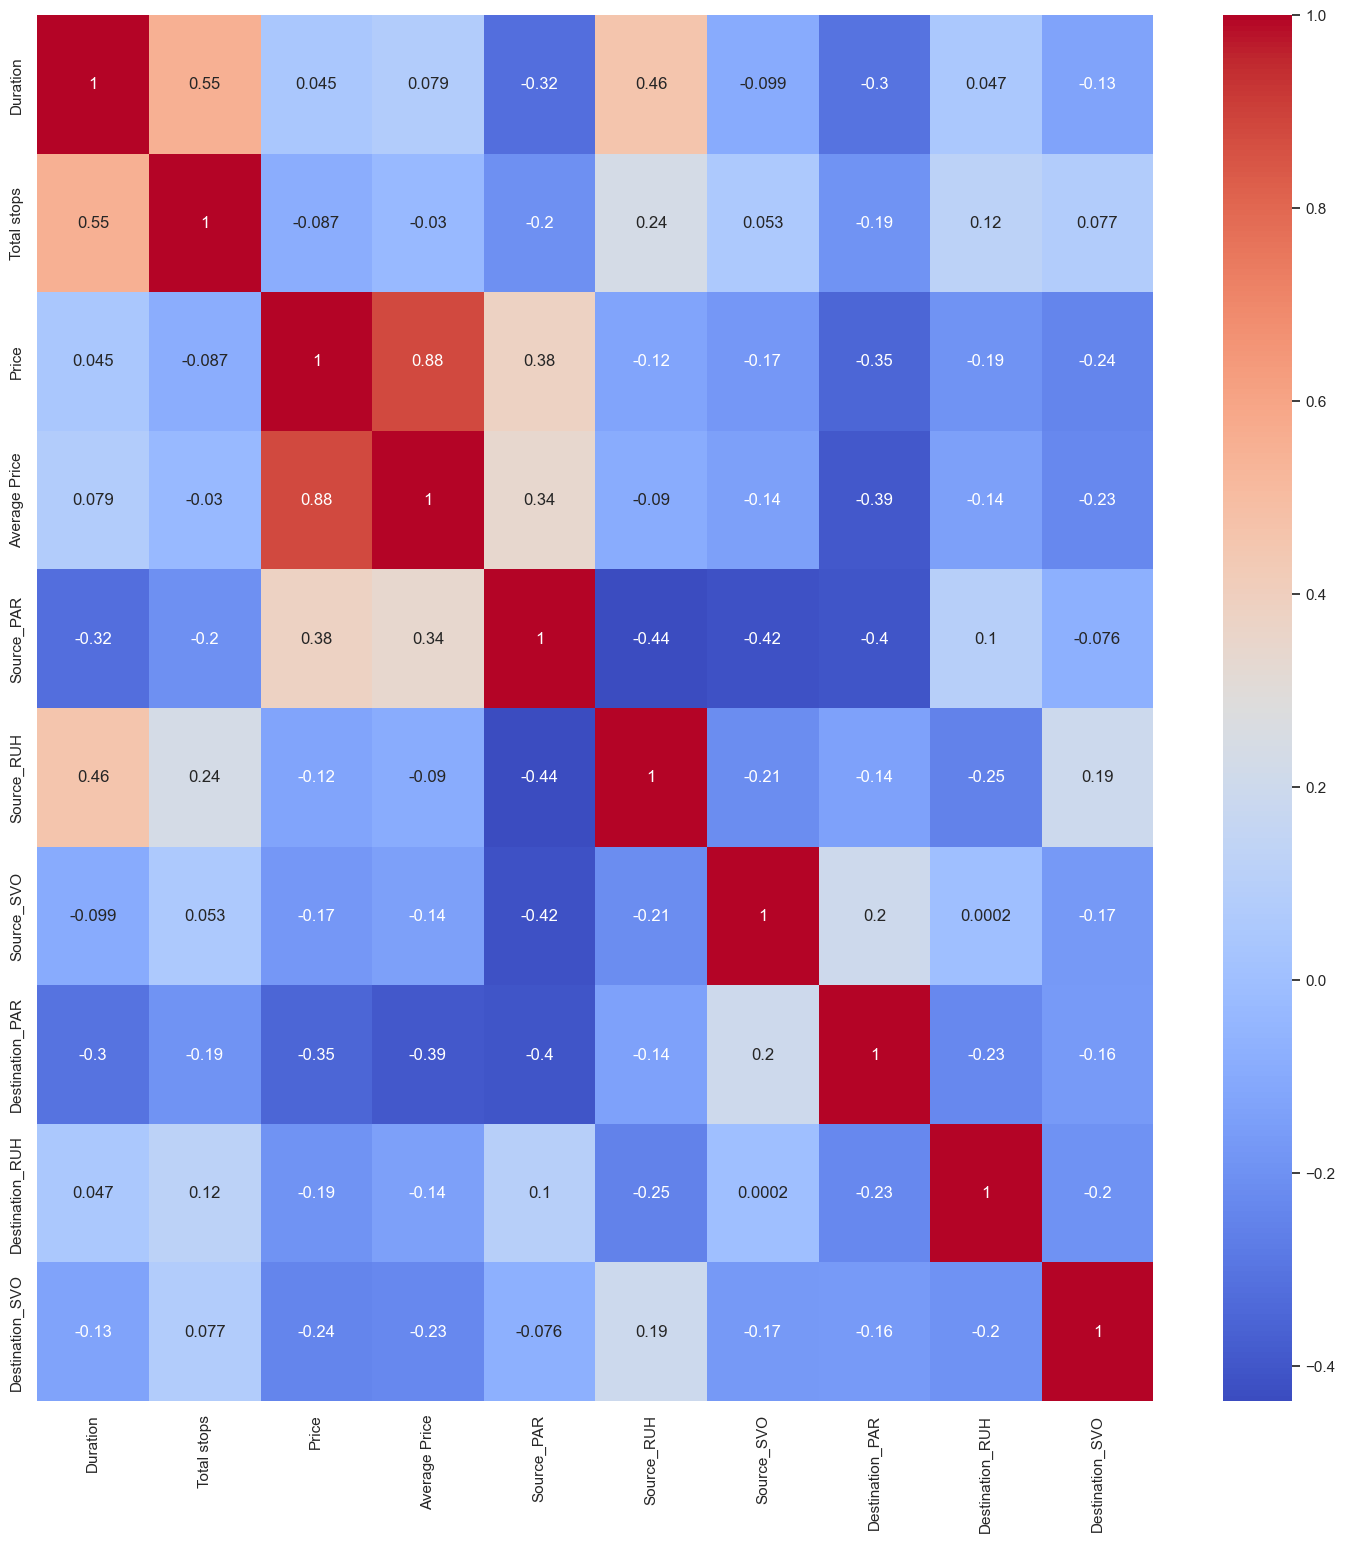

In [50]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [51]:
# getting feature importance to the target variable "Price"

selection =ExtraTreesRegressor()
selection.fit(x,y)
selection.feature_importances_

array([0.0398182 , 0.01416634, 0.7461402 , 0.08563861, 0.0074221 ,
       0.0128233 , 0.02435939, 0.05554378, 0.01408808])

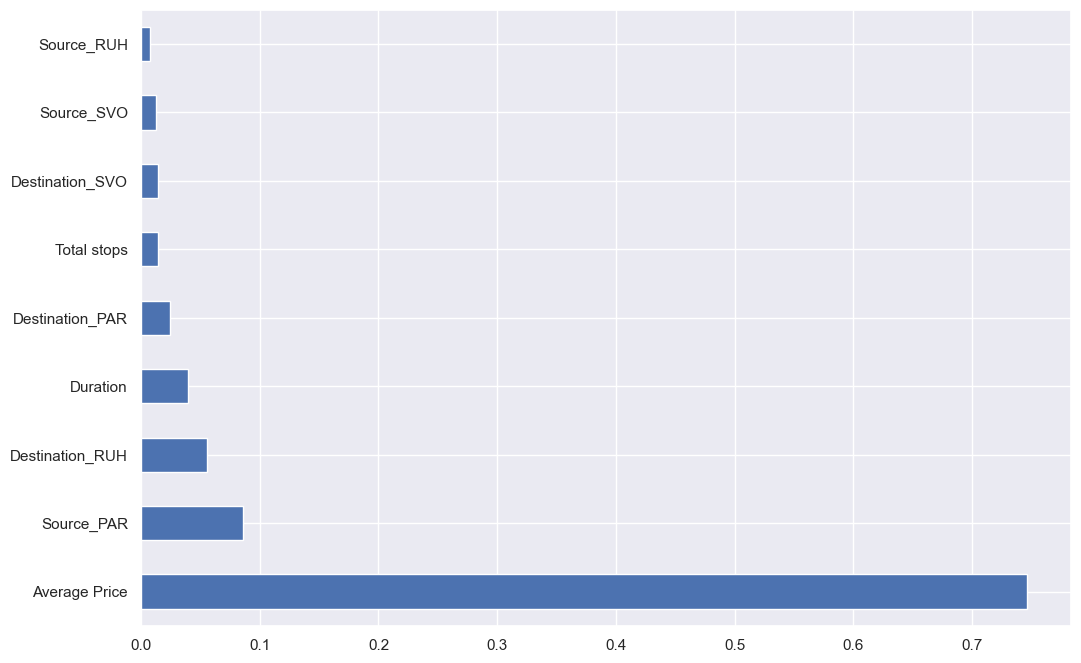

In [53]:
# plotting graph of important features

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = x.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

## Modeling: <a class="anchor" id="modeling"></a>

In [54]:
# 60% Train - 20% Val - 20% Test

x_train_or, x_test, y_train_or, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_or, y_train_or, test_size=0.25)

### Defining a function to get metrics for val set

In [55]:
def get_metrics(model):
    print(f'Train score {model.score(x_train, y_train)}')
    print(f'Val score {model.score(x_val, y_val)}')
    print("MAE:" , mean_absolute_error(y_val,model.predict(x_val)))
    print("MSE:" , mean_squared_error(y_val,model.predict(x_val)))
    print("RMSE:" , np.sqrt(mean_squared_error(y_val,model.predict(x_val))))

### Baseline Linear Regression

In [56]:
lr = LinearRegression()
lr.fit(x_train, y_train)
score = lr.score(x_val, y_val)
get_metrics(lr)

Train score 0.798765622780629
Val score 0.8094950727383554
MAE: 220.30218025447485
MSE: 139487.0140939099
RMSE: 373.47960331711545


### Polynomial 

In [59]:
for degree in [1, 2, 3, 4, 5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(x_train, y_train)
    print("-" * 20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.798765622780629
Val score 0.8094950727383556
MAE: 220.30218025448448
MSE: 139487.01409390982
RMSE: 373.47960331711533
--------------------
Degree 2
Train score 0.8543675369789744
Val score 0.8591198561353963
MAE: 175.0599683301858
MSE: 103151.92837928481
RMSE: 321.1727391596068
--------------------
Degree 3
Train score 0.8748205085761718
Val score 0.8761802821537705
MAE: 157.4375271399873
MSE: 90660.34656731041
RMSE: 301.09856619936005
--------------------
Degree 4
Train score 0.8798233352542592
Val score 0.876854637143126
MAE: 150.1075812778693
MSE: 90166.58629949685
RMSE: 300.2775154744305
--------------------
Degree 5
Train score 0.8844165943721116
Val score 0.8678421671221421
MAE: 152.11675926855708
MSE: 96765.4840335767
RMSE: 311.0715095176296


### Lasso

In [60]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
get_metrics(lasso_model)

Train score 0.7985756100955126
Val score 0.8093671729632956
MAE: 218.62594634142044
MSE: 139580.66184351308
RMSE: 373.6049542545081


### ElasticNet

In [61]:
EN_model = ElasticNet(alpha = 1)
EN_model.fit(x_train, y_train)
EN_model.score(x_val, y_val)
get_metrics(EN_model)

Train score 0.7839733929664978
Val score 0.7952223378445391
MAE: 220.10579041574036
MSE: 149937.458614739
RMSE: 387.2175856217522


### Random Forest

In [63]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
get_metrics(rf)

Train score 0.9666611868840459
Val score 0.9438008507395634
MAE: 61.722747072691455
MSE: 41148.81246189452
RMSE: 202.8517006630571


### Feature Scaling

In [65]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.values)
x_val_scaled = scaler.transform(x_val.values)
x_test_scaled = scaler.transform(x_test.values)

In [66]:
# function to get metrics for scaled features

def scaled_metrics(model):
    print(f'Train score {model.score(x_train_scaled, y_train)}')
    print(f'Val score {model.score(x_val_scaled, y_val)}')
    print("MAE:" , mean_absolute_error(y_val,model.predict(x_val_scaled)))
    print("MSE:" , mean_squared_error(y_val,model.predict(x_val_scaled)))
    print("RMSE:" , np.sqrt(mean_squared_error(y_val,model.predict(x_val_scaled))))

In [67]:
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
score = lr.score(x_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(x_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(x_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(x_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(x_train_scaled, y_train)
EN_model.score(x_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 0.798765622780629
Val score 0.8094950727383554
MAE: 220.3021802544741
MSE: 139487.0140939099
RMSE: 373.47960331711545
--------------------------------------------------
Polynomial - Degree 1
Train score -0.31305771953075334
Val score -0.29676159660589807
MAE: 752.5120587785547
MSE: 949484.1193990783
RMSE: 974.4147573795659
--------------------------------------------------


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature nam

Polynomial - Degree 2
Train score -6.573539417594923
Val score -6.438293781148584
MAE: 1811.9662087890936
MSE: 5446291.623002078
RMSE: 2333.729123742102
--------------------------------------------------


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature nam

Polynomial - Degree 3
Train score -7.00888351012574


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Val score -6.862308318816428
MAE: 1913.830305873958
MSE: 5756753.523604086


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 2399.323555422254
--------------------------------------------------
Polynomial - Degree 4


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -98.10377414088671
Val score -96.037091479131


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 5610.660268526274
MSE: 71050205.05948213


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 8429.128368905182
--------------------------------------------------
Polynomial - Degree 5


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Train score -1.167564232172495


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Val score -1.1456010422934768


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MAE: 916.0381615431005


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


MSE: 1571001.2708241087


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


RMSE: 1253.3958954871796
--------------------------------------------------
Lasso
Train score 0.7987480654035085
Val score 0.8094665795505501
MAE: 219.89461195705394
MSE: 139507.8767022745
RMSE: 373.50753232334483
--------------------------------------------------
Ridge
Train score 0.7987656219305259
Val score 0.809494856501784
MAE: 220.30482948964402
MSE: 139487.1724215402
RMSE: 373.4798152799428
--------------------------------------------------
ElasticNet
Train score 0.7308775010693698
Val score 0.7389552306259217
MAE: 302.8115289865452
MSE: 191136.02964617198
RMSE: 437.1910676651251
--------------------------------------------------
Random Forest


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Train score -1.0708368699705049
Val score -1.049986046060627
MAE: 875.680833242457


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


MSE: 1500992.3187259661
RMSE: 1225.1499168371054


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


#### Feature scaling was of no use, it did not improve anything.

**<br>From the above analysis, we can see that the random forest model performed the best with:</br>**

**Train score 0.9648778537711422**
**<br>Val score 0.9448134490695079</br>**
**<br>MAE: 61.717733027545194</br>**
**<br>MSE: 40035.31608101726</br>**
**<br>RMSE: 200.0882707232417</br>**

**So, we'll select it as our model.**

In [69]:
x_train_val = pd.concat([x_train,x_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(x_train_val,y_train_val)

print(f'Train score {rf.score(x_train_val, y_train_val)}')
print(f'Test score {rf.score(x_test, y_test)}')
print("MAE:" , mean_absolute_error(y_test,rf.predict(x_test)))
print("MSE:" , mean_squared_error(y_test,rf.predict(x_test)))
print("RMSE:" , np.sqrt(mean_squared_error(y_test,rf.predict(x_test))))

Train score 0.9638552567147459
Test score 0.9436823691503676
MAE: 61.33664529338316
MSE: 41903.97135100102
RMSE: 204.70459533435252


In [70]:
y_train_val_pred = rf.predict(x_train_val)
y_test_pred = rf.predict(x_test)

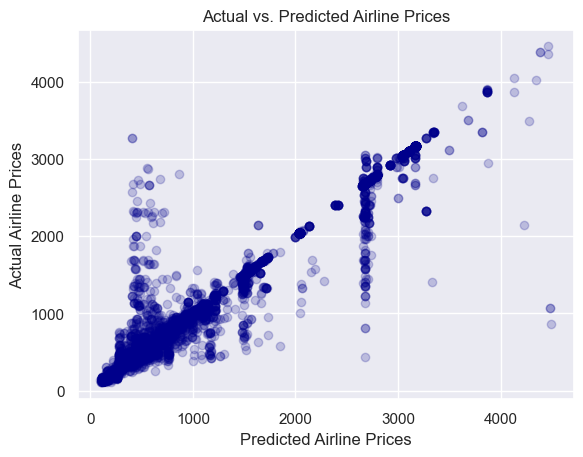

In [71]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [72]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [73]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [76]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [77]:
rf_random.fit(x_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=  18.4s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=  17.8s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=  16.8s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=  15.9s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=300; total time=  16.0s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  34.8s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  34.9s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  30.9s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  32.2s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  32.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   5.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   4.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   5.0s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   4.7s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=200; total time=   5.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.4s
[CV] END max_depth=20, max_f

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  42.7s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  41.8s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  40.8s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  40.5s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  39.5s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.0s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.2s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.0s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.2s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=700; total time=  11.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=700; total time=  15.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=700; total time=   9.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=700; total time=   9.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=700; total time=   9.3s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time= 1.0min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time= 1.1min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time=  49.5s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time= 1.2min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=5, min_samples_split=15, n_estimators=1000; total time= 1.3min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.4min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.2min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.1min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.1min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 1.2min


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1000; total time=  30.5s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1000; total time=  38.2s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1000; total time=  39.2s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1000; total time=  34.4s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1000; total time=  40.0s


C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [78]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 25}

In [79]:
prediction = rf_random.predict(x_test)

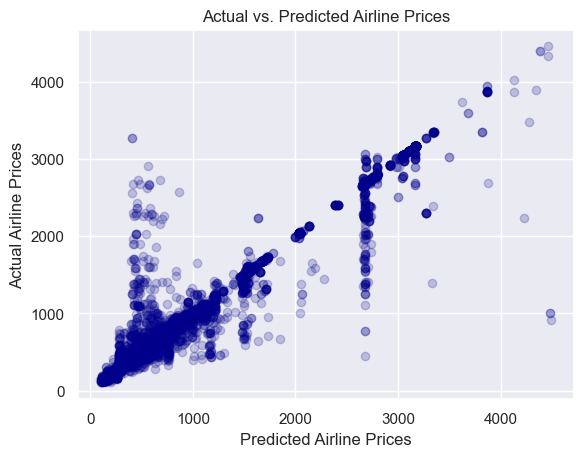

In [80]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [81]:
print("MAE:" , mean_absolute_error(y_test,prediction))
print("MSE:" , mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(mean_squared_error(y_test,prediction)))

MAE: 62.07837834239193
MSE: 41986.01859567354
RMSE: 204.9049013461453


#### Therefore, hyperparameter tuning did not improve the model

In [82]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(x_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,945.373423,916.00
1,388.130800,276.80
2,412.069546,411.20
3,3866.930000,3866.93
4,455.761117,454.67
...,...,...
10015,464.444381,366.13
10016,579.447162,435.47
10017,814.008536,810.40
10018,498.663428,454.67


## Saving The Final Model: <a class="anchor" id="model"></a>

In [88]:
# save the model

file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [89]:
# open the model

model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [90]:
print(f'R2 score {r2_score(y_test,rf_flight_prediction.predict(x_test))}')
print("MAE:" , mean_absolute_error(y_test,rf_flight_prediction.predict(x_test)))
print("MSE:" , mean_squared_error(y_test,rf_flight_prediction.predict(x_test)))
print("RMSE:" , np.sqrt(mean_squared_error(y_test,rf_flight_prediction.predict(x_test))))

R2 score 0.9436823691503676
MAE: 61.33664529338316
MSE: 41903.97135100102
RMSE: 204.70459533435252
